# Syntax trees

An expression can be thought of as a **syntax tree**. Julia allows us to access the **abstract syntax tree** (AST) it generates for **expression objects**. In this notebook, we will use this to draw actual syntax trees.

In [24]:
using LightGraphs, TikzGraphs
using MacroTools

## Expression objects

We can define an object representing an unevaluated Julia expression as follows:

In [25]:
ex = :(x^2 + y^2)

:(x ^ 2 + y ^ 2)

The `dump` command reveals its internal recursive structure:

In [27]:
dump(ex)

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol +
    2: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol ^
        2: Symbol x
        3: Int64 2
      typ: Any
    3: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol ^
        2: Symbol y
        3: Int64 2
      typ: Any
  typ: Any


## Draw a syntax tree

In [2]:
add_numbered_vertex!(g) = (add_vertex!(g); top = nv(g))  # returns the number of the new vertex

add_numbered_vertex! (generic function with 1 method)

In [3]:
"Convert the current node into a label"
function label(sym) 
    sym == :(^) && return "\\textasciicircum"  # TikzGraphs chokes on ^
    
    return string("\\texttt{", sym, "}")
end

label

In [4]:
"""Traverse the expression and build up the graph g and the set of labels
for each node. (These both get modified in place.) `show_call` specifies whether to include `call` nodes in the graph
in function calls. Including them represents the Julia AST more precisely, but adds a lot
of visual noise to the display.

traverse! returns the number of the vertex at the top of the subexpression."""

function traverse!(g, labels, ex, show_call=true)

    top_vertex = add_numbered_vertex!(g)
    
    start_argument = 1  # which argument to start with
    
    if !(show_call) && ex.head == :call 
        f = ex.args[1]   # the function name
        push!(labels, label(f))
        start_argument = 2   # drop "call" from tree
        
    else
        push!(labels, label(ex.head))
    end

    
    for i in start_argument:length(ex.args)
        
        if isa(ex.args[i], Expr)
            
            child = traverse!(g, labels, ex.args[i], show_call)
            add_edge!(g, top_vertex, child)
            
        else
            n = add_numbered_vertex!(g)
            add_edge!(g, top_vertex, n)
            
            push!(labels, label(ex.args[i]))
           
        end
    end
    
    return top_vertex
    
end

traverse!

In [15]:
function make_graph(ex::Expr, show_call=false)
    ex = MacroTools.striplines(ex)
    
    g = Graph()
    labels = String[]
    
    traverse!(g, labels, ex, show_call)
    
    return g, labels
    
end

make_graph (generic function with 2 methods)

In [5]:
function draw_syntax_tree(ex::Expr, show_call=false)
    
    ex = MacroTools.striplines(ex)
    
    g = Graph()
    labels = String[]
    
    traverse!(g, labels, ex, show_call)
    
    TikzGraphs.plot(g, labels)
end

draw_syntax_tree (generic function with 2 methods)

In [6]:
macro tree(ex::Expr)
    draw_syntax_tree(ex)
end

macro tree_with_call(ex::Expr)
    draw_syntax_tree(ex, true)
end

@tree_with_call (macro with 1 method)

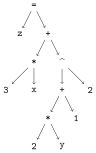

In [7]:
t = @tree z = 3x + (2y+1)^2

In [14]:
t.data

"\\graph [layered layout, ] {\n1/\"\\texttt{=}\" [],\n2/\"\\texttt{z}\" [],\n3/\"\\texttt{f}\" [],\n4/\"\\texttt{g}\" [],\n5/\"\\texttt{f}\" [],\n6/\"\\texttt{x}\" [],\n7/\"\\texttt{y}\" [],\n;\n1 -> [,] 2;\n1 -> [,] 3;\n3 -> [,] 4;\n4 -> [,] 5;\n5 -> [,] 6;\n5 -> [,] 7;\n};\n"

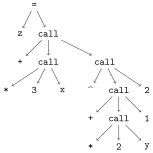

In [8]:
t = @tree_with_call z = 3x + (2y+1)^2

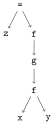

In [9]:
t = @tree z = f(g(f(x, y)))

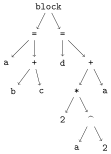

In [11]:
@tree begin
    a = b + c
    d = 2a^2 + a
end

There is no common subexpression elimination:

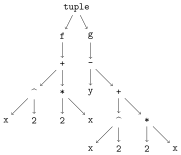

In [12]:
@tree (f(x^2 + 2x), g(y - (x^2 + 2x)))

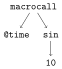

In [13]:
@tree @time sin(10)

## Labelled vertices:

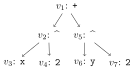

In [22]:
g, labels = make_graph(:(x^2 + y^2))

for i in 1:length(labels)
    labels[i] = string("\$v_", i, "\$: \$", labels[i], "\$")
end

TikzGraphs.plot(g, labels)

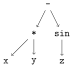

In [28]:
@tree x*y - sin(z)